### 功率模型


In [192]:

#导入基础库
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


In [193]:
#读取文件，更改数字即可测试另一个数据集
number = 2
str = ["stainless_steel_milling_energy_model",
        "high_speed_machining_energy_model", "laser_cleaning_energy_model", "milling_carbon_emission_model","data","data_1","data_2"]
figurename = ["不锈钢铣削中机床比能预测", "高速高精加工中心切削过程能耗",
                "激光清洗过程能耗", "铣削加工过程碳排放","CAK50135di车削加工","ACE-V500数控锐床能耗","基于数据系统的离散制造系统能耗"]
xfilename = "./data_read/"+f"{str[number]}.xlsx"
cfilename = "./data_read/"+f"{str[number]}.csv"




In [194]:
#注意数据格式，如果是csv用上面的，xlsx用下面的
# data = pd.read_csv(cfilename)
# data = pd.read_csv(cfilename,usecols=range(1, len(data.columns)))
# data

In [195]:
data = pd.read_excel(xfilename)
data = pd.read_excel(xfilename, usecols=range(1, len(data.columns)))
data

,单脉冲能量nmJ,行进速度𝑣𝑟mm/s,脉冲频率fKHz,运行功率𝑃𝑟𝑤𝑜W
0,50,10,10,462.08
1,60,10,10,470.44
2,70,10,10,477.01
3,80,10,10,483.02
4,90,10,10,483.06
5,100,10,10,476.25
6,100,10,5,467.53
7,100,10,6,458.59
8,100,10,7,464.75
9,100,10,8,468.97


In [196]:
list(data.columns)


['单脉冲能量nmJ', '行进速度𝑣𝑟mm/s', '脉冲频率fKHz', '运行功率𝑃𝑟𝑤𝑜W']

c:\Users\mr136\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 119875 (\N{MATHEMATICAL ITALIC CAPITAL P}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\mr136\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 119903 (\N{MATHEMATICAL ITALIC SMALL R}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\mr136\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 119908 (\N{MATHEMATICAL ITALIC SMALL W}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\mr136\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 119900 (\N{MATHEMATICAL ITALIC SMALL O}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\mr136\AppData\Local\Programs\Python\Python310\lib\site-packages\seabo

C:\Users\mr136\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 119875 (\N{MATHEMATICAL ITALIC CAPITAL P}) missing from current font.
  func(*args, **kwargs)
C:\Users\mr136\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 119903 (\N{MATHEMATICAL ITALIC SMALL R}) missing from current font.
  func(*args, **kwargs)
C:\Users\mr136\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 119908 (\N{MATHEMATICAL ITALIC SMALL W}) missing from current font.
  func(*args, **kwargs)
C:\Users\mr136\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 119900 (\N{MATHEMATICAL ITALIC SMALL O}) missing from current font.
  func(*args, **kwargs)
C:\Users\mr136\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 119907 (\N{MATHEMATICAL ITALIC SMALL V}) missing from current font.
  func(*args, **kwargs

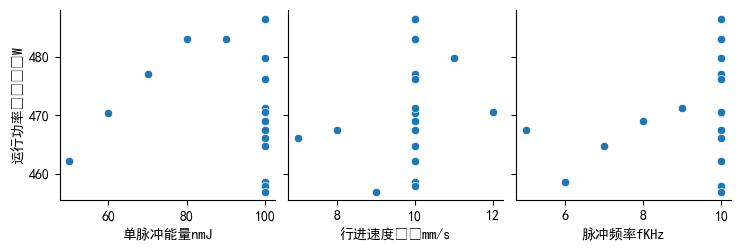

In [197]:
#观察各个feature与P(W)的关系
import seaborn as sns
sns.pairplot(data, x_vars=list(data.columns)[:-1], y_vars=list(data.columns)[-1])


In [198]:
a = np.array([1,2,3,4,5])
np.std(a)

1.4142135623730951

In [199]:
#搭建模型网络
class Pw_Model(nn.Module):
    def __init__(self, input_dim):
        super(Pw_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B, 1) -> (B)
        return x
    
#数据加载转换tensor类
class Pw_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [200]:
#hyperparameters配置
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'n_epochs': 1000,     # Number of epochs.
    'batch_size': 256,
    'learning_rate': 1e-4,
}


In [201]:
#标准化操作示例
data_normalized = data
data_normalized.apply(lambda x: (x - np.mean(x)) / (np.std(x)))


,单脉冲能量nmJ,行进速度𝑣𝑟mm/s,脉冲频率fKHz,运行功率𝑃𝑟𝑤𝑜W
0,-2.711631,0.164399,0.542326,-0.960990
1,-2.060839,0.164399,0.542326,-0.001084
2,-1.410048,0.164399,0.542326,0.753291
3,-0.759257,0.164399,0.542326,1.443367
4,-0.108465,0.164399,0.542326,1.447960
5,0.542326,0.164399,0.542326,0.666027
6,0.542326,0.164399,-2.711631,-0.335214
7,0.542326,0.164399,-2.060839,-1.361717
8,0.542326,0.164399,-1.410048,-0.654418
9,0.542326,0.164399,-0.759257,-0.169872


In [202]:
#初始化数据
#打乱
data = data.sample(frac=1.0)
#标准化(理论上先划分再归一化，这里偷懒了，对于data_1不归一化效果也很好，因为已经做过量纲处理了)
data_normalized = data.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
#划分训练集和验证集
divide = int(data.shape[0]*0.85)
train_data, test_data = data_normalized.iloc[:divide], data_normalized.iloc[divide:data.shape[0]]
train_data, test_data = train_data.values,test_data.values

train_y , test_y = train_data[:,-1],test_data[:,-1]
train_x , test_x = train_data[:,:-1],test_data[:,:-1]

train_dataset, test_dataset = Pw_Dataset(
    train_x, train_y), Pw_Dataset(test_x, test_y)
train_loader = DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)


In [203]:
#优化函数，损失函数，数据迁移
model = Pw_Model(input_dim=train_x.shape[1]).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(
    model.parameters(), lr=config['learning_rate'])



In [204]:
#训练
def trainer(train_loader, model, config, device):
    n_epochs,step = config['n_epochs'],0
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, leave=False)
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            # Compute gradient(backpropagation).
            loss.backward()
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
        mean_train_loss = sum(loss_record)/len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss: .8f}')
    return loss_record


In [205]:
#测试
def test(test_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    loss_record = []
    predict = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            predict.append(pred)
            loss = criterion(pred, y)
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    with open("./renderings/test_score.txt", "a") as file:
        file.write(figurename[number]+"模型\n")
        file.write(f'test loss: {mean_test_loss:.8f}\n')
    return predict


Epoch[50/1000]: Train loss:  0.92260206


Epoch[100/1000]: Train loss:  0.85225960


Epoch[150/1000]: Train loss:  0.80719887


Epoch[200/1000]: Train loss:  0.77183903


Epoch[250/1000]: Train loss:  0.74066053


Epoch[300/1000]: Train loss:  0.71177971


Epoch[350/1000]: Train loss:  0.68487404


Epoch[400/1000]: Train loss:  0.66029192


Epoch[450/1000]: Train loss:  0.63842211


Epoch[500/1000]: Train loss:  0.61922624


Epoch[550/1000]: Train loss:  0.60239636


Epoch[600/1000]: Train loss:  0.58764833


Epoch[650/1000]: Train loss:  0.57469509


Epoch[700/1000]: Train loss:  0.56325353


Epoch[750/1000]: Train loss:  0.55307001


Epoch[800/1000]: Train loss:  0.54393161


Epoch[850/1000]: Train loss:  0.53562249


Epoch[900/1000]: Train loss:  0.52804289


Epoch[950/1000]: Train loss:  0.52109858


Epoch[1000/1000]: Train loss:  0.51470277


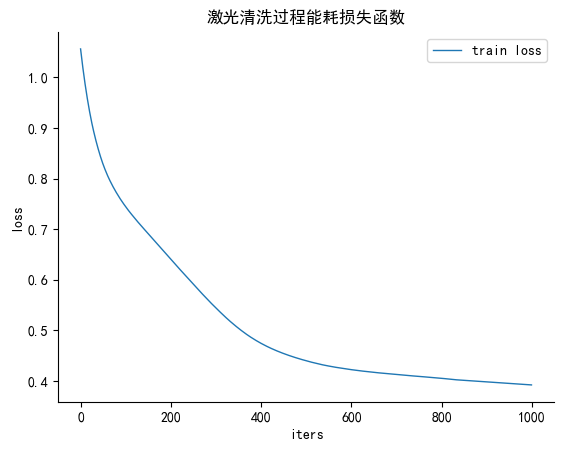

In [206]:
y_train_loss = trainer(train_loader, model, config, device)      # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,
         linestyle="solid", label="train loss")
plt.legend()
plt.title(figurename[number]+"损失函数")
plt.savefig("./renderings/"+figurename[number]+"损失函数")
plt.show()


In [207]:
predict = test(test_loader,model,device)
predict

[tensor([ 1.4537, -0.6379, -0.9987], device='cuda:0')]

In [208]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs/

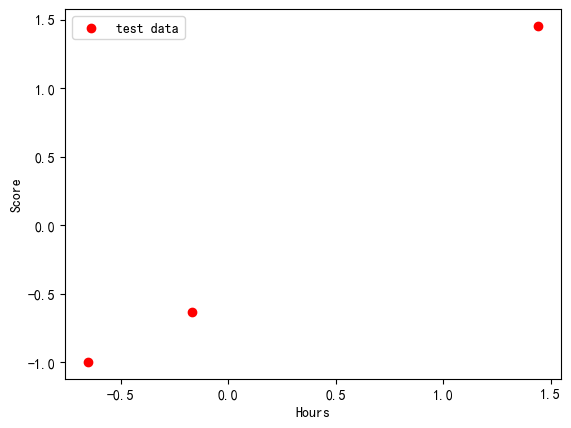

0.8600559448783189


In [209]:
from sklearn.metrics import r2_score
real= np.array(test_y)
compute = predict[0].cuda().cpu().numpy()
#测试数据散点图
plt.scatter(real, compute, color='red', label="test data")
#添加图标标签
plt.legend(loc=2)
plt.xlabel("Hours")
plt.ylabel("Score")
#显示图像
save_fig = "./score/"+figurename[number]
plt.savefig(save_fig+"score")
plt.show()
#计算拟合优度
score = r2_score(real, compute)
print(score)


In [210]:
save_name = "./save/"+str[number]+".pt"
torch.save(model,save_name)
